# Pain Classification Pipeline - Multi-class LSTM

Clean pipeline for pain classification using LSTM on time series data.

## 1. Setup

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
 )
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Create figures directory
Path('./figures').mkdir(exist_ok=True)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.2.6
Pandas version: 2.3.3


## 2. Data Loading

In [61]:
# Load data files
train_df = pd.read_csv('pirate_pain_train.csv')
labels_df = pd.read_csv('pirate_pain_train_labels.csv')
test_df = pd.read_csv('pirate_pain_test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Merge labels with train data
train_df = train_df.merge(labels_df, on='sample_index', how='left')

# Sort by time within each sequence
train_df = train_df.sort_values(['sample_index', 'time']).reset_index(drop=True)
test_df = test_df.sort_values(['sample_index', 'time']).reset_index(drop=True)

print("Data loaded successfully")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Data loaded successfully
Train shape: (105760, 41)
Test shape: (211840, 40)
Sample submission shape: (1324, 2)


In [62]:
# Data statistics
print("\n=== Label Distribution ===")
label_col = [col for col in train_df.columns if col not in test_df.columns and col != 'sample_index'][0]
train_label_series = train_df.groupby('sample_index')[label_col].first()
print(f"Label column: {label_col}")
print(train_label_series.value_counts().sort_index())

# Fixed label mapping: ensure deterministic encoding
label_to_id = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
expected_labels = set(label_to_id.keys())
observed_labels = set(train_label_series.unique())
if observed_labels != expected_labels:
    missing = expected_labels - observed_labels
    unexpected = observed_labels - expected_labels
    raise ValueError(f"Label mismatch. Missing: {missing}, Unexpected: {unexpected}")

id_to_label = {idx: label for label, idx in label_to_id.items()}
label_mapping_path = Path('label_mapping.json')
with open(label_mapping_path, 'w') as f:
    json.dump({'label_to_id': label_to_id, 'id_to_label': id_to_label}, f, indent=2)
print(f"\nLabel mapping saved to {label_mapping_path.resolve()}")

# Encode labels
train_df[label_col] = train_df[label_col].map(label_to_id)
if train_df[label_col].isna().any():
    raise ValueError("Label encoding produced NaNs; check mapping.")

print(f"\nLabel to index mapping: {label_to_id}")

num_classes = len(label_to_id)
print(f"\nNumber of classes: {num_classes}")

# Sequence length statistics
train_seq_lengths = train_df.groupby('sample_index').size()
test_seq_lengths = test_df.groupby('sample_index').size()

print("\n=== Training Sequence Lengths ===")
print(f"Min: {train_seq_lengths.min()}")
print(f"Median: {train_seq_lengths.median():.0f}")
print(f"Max: {train_seq_lengths.max()}")
print(f"Total sequences: {len(train_seq_lengths)}")

print("\n=== Test Sequence Lengths ===")
print(f"Min: {test_seq_lengths.min()}")
print(f"Median: {test_seq_lengths.median():.0f}")
print(f"Max: {test_seq_lengths.max()}")
print(f"Total sequences: {len(test_seq_lengths)}")


=== Label Distribution ===
Label column: label
label
high_pain     56
low_pain      94
no_pain      511
Name: count, dtype: int64

Label mapping saved to C:\Users\filip\Documents\GitHub\challenge_an2dl\label_mapping.json

Label to index mapping: {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}

Number of classes: 3

=== Training Sequence Lengths ===
Min: 160
Median: 160
Max: 160
Total sequences: 661

=== Test Sequence Lengths ===
Min: 160
Median: 160
Max: 160
Total sequences: 1324


In [63]:
# Stratified train/validation split at sequence level
sample_labels = train_df.groupby('sample_index')[label_col].first()
train_indices, val_indices = train_test_split(
    sample_labels.index,
    test_size=0.2,
    random_state=SEED,
    stratify=sample_labels
 )
train_indices = np.array(sorted(train_indices))
val_indices = np.array(sorted(val_indices))

print("\n=== Train/Validation Split ===")
print(f"Train sequences: {len(train_indices)}")
print(f"Validation sequences: {len(val_indices)}")
print(f"Class distribution (train):\n{sample_labels.loc[train_indices].value_counts().sort_index()}")
print(f"Class distribution (val):\n{sample_labels.loc[val_indices].value_counts().sort_index()}")


=== Train/Validation Split ===
Train sequences: 528
Validation sequences: 133
Class distribution (train):
label
0    408
1     75
2     45
Name: count, dtype: int64
Class distribution (val):
label
0    103
1     19
2     11
Name: count, dtype: int64

Train sequences: 528
Validation sequences: 133
Class distribution (train):
label
0    408
1     75
2     45
Name: count, dtype: int64
Class distribution (val):
label
0    103
1     19
2     11
Name: count, dtype: int64


## 3. Feature Groups Definition

In [64]:
# Identify feature columns
exclude_cols = {'sample_index', 'time', label_col}
all_feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# JOINT features: joint_00 to joint_30 (continuous, time-varying)
joint_cols = [col for col in all_feature_cols if col.startswith('joint_')]

# SURVEY features: pain_survey_1 to pain_survey_4 (ordinal 0/1/2)
survey_cols = [col for col in all_feature_cols if col.startswith('pain_survey_')]

# BODY features: static subject features
body_cols = [col for col in all_feature_cols if col not in joint_cols + survey_cols]

# Separate body into categorical and continuous
body_cat_cols = [col for col in body_cols if train_df[col].dtype == 'object']
body_cont_cols = [col for col in body_cols if col not in body_cat_cols]

print("=== Feature Groups ===")
print(f"JOINT features ({len(joint_cols)}): {joint_cols[:3] if len(joint_cols) >= 3 else joint_cols}...{joint_cols[-3:] if len(joint_cols) >= 3 else []}")
print(f"SURVEY features ({len(survey_cols)}): {survey_cols}")
print(f"BODY categorical ({len(body_cat_cols)}): {body_cat_cols}")
print(f"BODY continuous ({len(body_cont_cols)}): {body_cont_cols}")
print(f"\nTotal features: {len(all_feature_cols)}")

=== Feature Groups ===
JOINT features (31): ['joint_00', 'joint_01', 'joint_02']...['joint_28', 'joint_29', 'joint_30']
SURVEY features (4): ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
BODY categorical (3): ['n_legs', 'n_hands', 'n_eyes']
BODY continuous (0): []

Total features: 38

JOINT features (31): ['joint_00', 'joint_01', 'joint_02']...['joint_28', 'joint_29', 'joint_30']
SURVEY features (4): ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
BODY categorical (3): ['n_legs', 'n_hands', 'n_eyes']
BODY continuous (0): []

Total features: 38


## 4. Preprocessing

In [65]:
def preprocess_data(df, is_train=True, scaler_joint=None, scaler_survey=None, body_cat_medians=None):
    """
    Preprocess data:
    - Interpolate NaN in JOINT features only
    - Map categorical BODY features to numeric
    - Fill missing BODY categorical with median
    - Scale JOINT and BODY continuous features
    - Optionally scale SURVEY features with MinMax to [0,1]
    """
    df = df.copy()
    
    # 1. Interpolate JOINT features (only NaN, not zeros)
    for col in joint_cols:
        if col in df.columns:
            df[col] = df.groupby('sample_index')[col].transform(
                lambda x: x.interpolate(method='linear', limit_direction='both')
            )
    
    # 2. Map categorical BODY features to numeric
    body_cat_mapping = {
        'zero': 0, 'one': 1, 'two': 2, 'three': 3
    }
    
    for col in body_cat_cols:
        if col in df.columns:
            df[col] = df[col].map(body_cat_mapping)
    
    # 3. Fill missing BODY categorical with median (training set)
    if is_train:
        body_cat_medians = {}
        for col in body_cat_cols:
            if col in df.columns:
                median_val = df.groupby('sample_index')[col].first().median()
                body_cat_medians[col] = median_val
                df[col] = df.groupby('sample_index')[col].transform(
                    lambda x: x.fillna(median_val)
                )
    else:
        for col in body_cat_cols:
            if col in df.columns and col in body_cat_medians:
                df[col] = df.groupby('sample_index')[col].transform(
                    lambda x: x.fillna(body_cat_medians[col])
                )
    
    # 4. Replicate BODY features across all timesteps (they are static per sequence)
    for col in body_cols:
        if col in df.columns:
            df[col] = df.groupby('sample_index')[col].transform('first')
    
    # 5. Scaling
    scale_cols_joint_body = joint_cols + body_cont_cols
    
    if is_train:
        if scale_cols_joint_body:
            scaler_joint = StandardScaler()
            df[scale_cols_joint_body] = scaler_joint.fit_transform(df[scale_cols_joint_body])
        
        if survey_cols:
            scaler_survey = MinMaxScaler(feature_range=(0, 1))
            df[survey_cols] = scaler_survey.fit_transform(df[survey_cols])
    else:
        if scale_cols_joint_body and scaler_joint is not None:
            df[scale_cols_joint_body] = scaler_joint.transform(df[scale_cols_joint_body])
        
        if survey_cols and scaler_survey is not None:
            df[survey_cols] = scaler_survey.transform(df[survey_cols])
    
    return df, scaler_joint, scaler_survey, body_cat_medians

# Split processed dataframe into train/validation subsets
train_df_train = train_df[train_df['sample_index'].isin(train_indices)].copy()
train_df_val = train_df[train_df['sample_index'].isin(val_indices)].copy()

# Preprocess datasets using training fit for scalers/medians
train_df_train, scaler_joint, scaler_survey, body_cat_medians = preprocess_data(
    train_df_train, is_train=True
 )

train_df_val, _, _, _ = preprocess_data(
    train_df_val, is_train=False,
    scaler_joint=scaler_joint,
    scaler_survey=scaler_survey,
    body_cat_medians=body_cat_medians
 )

test_df_processed, _, _, _ = preprocess_data(
    test_df, is_train=False,
    scaler_joint=scaler_joint,
    scaler_survey=scaler_survey,
    body_cat_medians=body_cat_medians
 )
test_df = test_df_processed

print("Preprocessing completed")
print(f"Training data shape: {train_df_train.shape}")
print(f"Validation data shape: {train_df_val.shape}")
print(f"Test data shape: {test_df.shape}")

Preprocessing completed
Training data shape: (84480, 41)
Validation data shape: (21280, 41)
Test data shape: (211840, 40)


## 5. Sequence Length Uniformization

In [66]:
def create_sequences(df, label_col=None, T_target=None):
    """
    Convert dataframe to sequences of uniform length.
    - If sequence is shorter than T_target: edge padding (repeat last frame)
    - If sequence is longer than T_target: truncate from the end
    """
    feature_cols = joint_cols + survey_cols + body_cols
    
    # Calculate T_target from training data if not provided
    if T_target is None:
        seq_lengths = df.groupby('sample_index').size()
        T_target = int(seq_lengths.max())
        print(f"T_target automatically set to: {T_target}")
    
    X_list = []
    y_list = []
    sample_indices = []
    
    for sample_idx in df['sample_index'].unique():
        seq_df = df[df['sample_index'] == sample_idx].sort_values('time')
        
        # Extract features
        seq_features = seq_df[feature_cols].values
        seq_len = len(seq_features)
        
        # Pad or truncate to T_target
        if seq_len < T_target:
            padding = np.repeat(seq_features[-1:], T_target - seq_len, axis=0)
            seq_features = np.vstack([seq_features, padding])
        elif seq_len > T_target:
            seq_features = seq_features[:T_target]
        
        X_list.append(seq_features)
        sample_indices.append(sample_idx)
        
        if label_col is not None:
            y_list.append(seq_df[label_col].iloc[0])
    
    X = np.array(X_list)
    
    expected_shape = (len(X), T_target, len(feature_cols))
    assert X.shape == expected_shape, f"Shape mismatch: {X.shape} != {expected_shape}"
    print(f"Sequences created: {X.shape}")
    
    if label_col is not None:
        y = np.array(y_list)
        return X, y, T_target, sample_indices
    else:
        return X, None, T_target, sample_indices

# Create sequences for each split
X_train, y_train, T_target, train_sample_indices = create_sequences(
    train_df_train, label_col=label_col, T_target=None
 )

X_val, y_val, _, val_sample_indices = create_sequences(
    train_df_val, label_col=label_col, T_target=T_target
 )

X_test, _, _, test_sample_indices = create_sequences(
    test_df, label_col=None, T_target=T_target
 )

print(f"\n=== Sequence Shapes ===")
print(f"T_target: {T_target}")
print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")
print(f"Number of features: {X_train.shape[2]}")

# Compute class weights to address class imbalance
class_weight_values = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weight_values)}
print(f"Class weights: {class_weights}")

T_target automatically set to: 160
Sequences created: (528, 160, 38)
Sequences created: (528, 160, 38)
Sequences created: (133, 160, 38)
Sequences created: (133, 160, 38)
Sequences created: (1324, 160, 38)

=== Sequence Shapes ===
T_target: 160
Training sequences: (528, 160, 38)
Validation sequences: (133, 160, 38)
Test sequences: (1324, 160, 38)
Number of features: 38
Class weights: {0: np.float64(0.43137254901960786), 1: np.float64(2.3466666666666667), 2: np.float64(3.911111111111111)}
Sequences created: (1324, 160, 38)

=== Sequence Shapes ===
T_target: 160
Training sequences: (528, 160, 38)
Validation sequences: (133, 160, 38)
Test sequences: (1324, 160, 38)
Number of features: 38
Class weights: {0: np.float64(0.43137254901960786), 1: np.float64(2.3466666666666667), 2: np.float64(3.911111111111111)}


In [67]:
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (528, 160, 38), (528,)
Validation set: (133, 160, 38), (133,)
Test set: (1324, 160, 38)


## 6. Model Architecture

In [71]:
def build_model(
    input_shape, num_classes,
    units1=128, units2=64, head_units=64,
    lr=6e-4, weight_decay=1e-4,
    dropout=0.15, spatial_do=0.15,
    bidirectional_first=True,   # <- NOVITÀ: BiLSTM opzionale
    label_smoothing=0.03        # <- NOVITÀ: smoothing
):
    inputs = layers.Input(shape=input_shape)

    # Spatial dropout (sui canali/feature)
    x = layers.SpatialDropout1D(spatial_do)(inputs)

    # Primo ricorrente (BiLSTM opzionale)
    if bidirectional_first:
        x = layers.Bidirectional(
            layers.LSTM(units1, return_sequences=True,
                        dropout=dropout, recurrent_dropout=0.1)
        )(x)
    else:
        x = layers.LSTM(units1, return_sequences=True,
                        dropout=dropout, recurrent_dropout=0.1)(x)
    x = layers.LayerNormalization()(x)

    # Secondo LSTM
    x = layers.LSTM(units2, return_sequences=True,
                    dropout=dropout, recurrent_dropout=0.1)(x)
    x = layers.LayerNormalization()(x)

    # Pooling globale (robusto per F1)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])

    # Testa densa (GELU + dropout)
    x = layers.Dense(head_units)(x)
    x = layers.Activation(tf.nn.gelu)(x)   # <- GELU
    x = layers.Dropout(0.30)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    # AdamW con clip norm
    optimizer = optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay, clipnorm=1.0)

    # Sparse CE con label smoothing (aiuta classi sbilanciate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=label_smoothing)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model


class MacroF1EarlyStopping(callbacks.Callback):
    """Early stopping based on validation macro-F1 score."""
    def __init__(self, validation_data, patience=10, min_delta=0.0, restore_best_weights=True, verbose=0):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.best_macro_f1 = -np.inf
        self.best_weights = None
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_labels = np.argmax(y_pred, axis=1)
        macro_f1 = f1_score(self.y_val, y_pred_labels, average='macro')
        logs['val_macro_f1'] = macro_f1

        if self.verbose:
            print(f"Epoch {epoch+1}: val_macro_f1={macro_f1:.4f}")

        if macro_f1 > self.best_macro_f1 + self.min_delta:
            self.best_macro_f1 = macro_f1
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait > self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
                if self.verbose:
                    print(f"Restoring best weights from epoch {epoch - self.wait + 1}")


# Build test model
test_model = build_model(
    input_shape=(T_target, X_train.shape[2]),
    num_classes=num_classes
)
test_model.summary()

ValueError: Invalid value for argument `reduction`. Expected one of {'sum', None, 'mean', 'mean_with_sample_weight', 'sum_over_batch_size', 'none'}. Received: reduction=auto

## 7. Grid Search

In [ ]:
# Define grid search configurations
grid_configs = [
    # solida e veloce (baseline migliorata)
    {'units1':128, 'units2':64, 'head_units':64,  'lr':6e-4, 'weight_decay':1e-4,
     'dropout':0.2, 'spatial_do':0.15, 'bidirectional_first':False, 'label_smoothing':0.03},

    # un po’ più capace
    {'units1':160, 'units2':80, 'head_units':64,  'lr':6e-4, 'weight_decay':1e-4,
     'dropout':0.2, 'spatial_do':0.15, 'bidirectional_first':True,  'label_smoothing':0.04},

    # testa più ampia + wd più alto (anti-overfit)
    {'units1':128, 'units2':64, 'head_units':96,  'lr':5e-4, 'weight_decay':2e-4,
     'dropout':0.25,'spatial_do':0.15, 'bidirectional_first':True,  'label_smoothing':0.05},

    # più leggera (se vedi overfit/rumore)
    {'units1':96,  'units2':64, 'head_units':64,  'lr':7e-4, 'weight_decay':1e-4,
     'dropout':0.25,'spatial_do':0.2,  'bidirectional_first':False, 'label_smoothing':0.04},
]


Testing 2 configurations
Each configuration will be evaluated on validation set using F1 macro score


In [ ]:
# Grid search execution
best_f1_macro = 0
best_config = None
best_model = None
grid_results = []

for idx, config in enumerate(grid_configs):
    print(f"\n{'='*60}")
    print(f"Testing config {idx+1}/{len(grid_configs)}: {config}")
    print('='*60)
    
    # Reset seeds
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    # Build model
    model = build_model(
        input_shape=(T_target, X_train.shape[2]),
        num_classes=num_classes,
        units1=config['units1'],
        units2=config['units2'],
        head_units=config['head_units'],
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )
    
    # Callbacks
    f1_early_stop = MacroF1EarlyStopping(
        validation_data=(X_val, y_val),
        patience=10,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_macro_f1', mode='max',
    factor=0.5, patience=4, min_lr=1e-5, verbose=0
)

    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[f1_early_stop, reduce_lr],
        class_weight=class_weights,
        verbose=0
    )
    
    # Evaluate
    y_val_proba_tmp = model.predict(X_val, verbose=0)
    y_val_pred = y_val_proba_tmp.argmax(axis=1)
    
    # Calculate metrics
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_per_class = f1_score(y_val, y_val_pred, average=None)
    accuracy = (y_val_pred == y_val).mean()
    
    result = {
        'config': config,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class.tolist(),
        'accuracy': accuracy,
        'epochs_trained': len(history.history['loss']),
        'best_val_macro_f1': f1_early_stop.best_macro_f1
    }
    grid_results.append(result)
    
    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 per class: {[f'{f:.4f}' for f in f1_per_class]}")
    print(f"Epochs trained: {result['epochs_trained']}")
    print(f"Best val macro-F1 observed: {f1_early_stop.best_macro_f1:.4f}")
    
    # Update best model
    if f1_macro > best_f1_macro:
        best_f1_macro = f1_macro
        best_config = config
        best_model = model
        print("*** New best model! ***")

print(f"\n{'='*60}")
print("Grid search completed")
print(f"Best config: {best_config}")
print(f"Best F1 Macro: {best_f1_macro:.4f}")

# Save best config
with open('best_config.json', 'w') as f:
    json.dump({
        'config': best_config,
        'f1_macro': best_f1_macro,
        'T_target': T_target
    }, f, indent=2)
print("\nBest config saved to best_config.json")


Testing config 1/2: {'units1': 128, 'units2': 64, 'head_units': 96, 'lr': 0.0007, 'weight_decay': 0.0002}
F1 Macro: 0.6826
Accuracy: 0.8346
F1 per class: ['0.9064', '0.7568', '0.3846']
Epochs trained: 22
Best val macro-F1 observed: 0.6826
*** New best model! ***

Testing config 2/2: {'units1': 128, 'units2': 48, 'head_units': 64, 'lr': 0.0006, 'weight_decay': 0.0002}
F1 Macro: 0.6826
Accuracy: 0.8346
F1 per class: ['0.9064', '0.7568', '0.3846']
Epochs trained: 22
Best val macro-F1 observed: 0.6826
*** New best model! ***

Testing config 2/2: {'units1': 128, 'units2': 48, 'head_units': 64, 'lr': 0.0006, 'weight_decay': 0.0002}
F1 Macro: 0.7288
Accuracy: 0.8421
F1 per class: ['0.9036', '0.8000', '0.4828']
Epochs trained: 33
Best val macro-F1 observed: 0.7288
*** New best model! ***

Grid search completed
Best config: {'units1': 128, 'units2': 48, 'head_units': 64, 'lr': 0.0006, 'weight_decay': 0.0002}
Best F1 Macro: 0.7288

Best config saved to best_config.json
F1 Macro: 0.7288
Accuracy

## 8. Final Training with Best Model

In [ ]:
# The best model is already trained from grid search
# Get predictions for evaluation
y_val_pred = best_model.predict(X_val, verbose=0).argmax(axis=1)
y_val_proba = best_model.predict(X_val, verbose=0)

print("Best model ready for evaluation")
print(f"Validation accuracy: {(y_val_pred == y_val).mean():.4f}")
print(f"Validation F1 macro: {f1_score(y_val, y_val_pred, average='macro'):.4f}")

Best model ready for evaluation
Validation accuracy: 0.8421
Validation F1 macro: 0.7288


## 9. Evaluation and Visualization

In [ ]:
# Retrain best model to get clean history for plots
np.random.seed(SEED)
tf.random.set_seed(SEED)

best_config_kwargs = best_config.copy()
if 'wd' in best_config_kwargs:
    best_config_kwargs['weight_decay'] = best_config_kwargs.pop('wd')

final_model = build_model(
    input_shape=(T_target, X_train.shape[2]),
    num_classes=num_classes,
    **best_config_kwargs
 )

f1_early_stop = MacroF1EarlyStopping(
    validation_data=(X_val, y_val),
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
 )

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
 )

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[f1_early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
 )

best_model = final_model
print(f"Best validation macro-F1 (retrain): {f1_early_stop.best_macro_f1:.4f}")

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4369 - loss: 1.3519Epoch 1: val_macro_f1=0.4372
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.4299 - loss: 1.3064 - val_accuracy: 0.5789 - val_loss: 0.9429 - val_macro_f1: 0.4372 - learning_rate: 6.0000e-04
Epoch 2/100
Epoch 1: val_macro_f1=0.4372
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.4299 - loss: 1.3064 - val_accuracy: 0.5789 - val_loss: 0.9429 - val_macro_f1: 0.4372 - learning_rate: 6.0000e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5157 - loss: 1.0680Epoch 2: val_macro_f1=0.6317
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.5530 - loss: 1.0364 - val_accuracy: 0.7744 - val_loss: 0.7874 - val_macro_f1: 0.6317 - learning_rate: 6.0000e-04
Epoch 3/100
Epoch 2: val_macro_f1=0.6317
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.5530 - loss: 1.0364 - val_accuracy: 0.7744 - val_loss: 0.7874 - val_macro_f1: 0.6317 - learning_rate: 6.0000e-04
Epoch 3/100
17

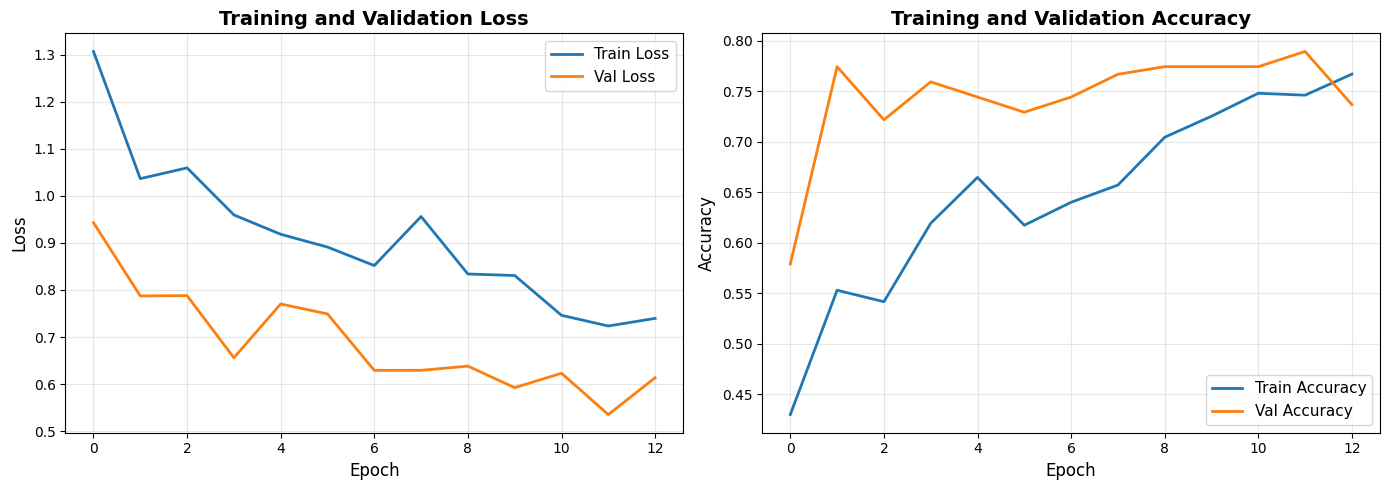

Training curves saved to ./figures/training_curves.png


In [ ]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Training curves saved to ./figures/training_curves.png")

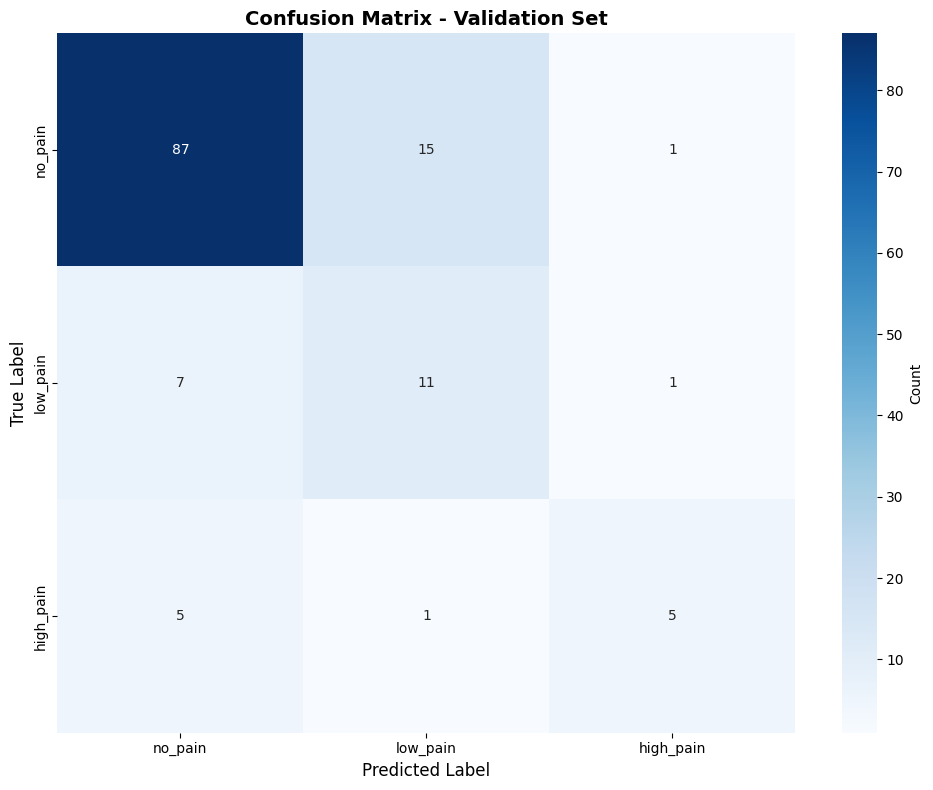

Confusion matrix saved to ./figures/confusion_matrix.png


In [ ]:
# Confusion Matrix
y_val_pred = best_model.predict(X_val, verbose=0).argmax(axis=1)
cm = confusion_matrix(y_val, y_val_pred, labels=range(num_classes))
label_names = [id_to_label[i] for i in range(num_classes)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, 
            yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrix saved to ./figures/confusion_matrix.png")

In [ ]:
# Classification Report
print("\n=== Label Mapping (index -> label) ===")
for idx in range(num_classes):
    print(f"  {idx}: {id_to_label[idx]}")

print("\n=== Classification Report ===")
target_names = [id_to_label[i] for i in range(num_classes)]
report = classification_report(y_val, y_val_pred, target_names=target_names, digits=4)
print(report)

# Calculate and display per-class F1 and macro F1
f1_per_class = f1_score(y_val, y_val_pred, average=None)
f1_macro = f1_score(y_val, y_val_pred, average='macro')

print("\n=== F1 Scores ===")
for idx, f1 in enumerate(f1_per_class):
    print(f"  {id_to_label[idx]}: {f1:.4f}")
print(f"\nMacro F1: {f1_macro:.4f}")


=== Label Mapping (index -> label) ===
  0: no_pain
  1: low_pain
  2: high_pain

=== Classification Report ===
              precision    recall  f1-score   support

     no_pain     0.8788    0.8447    0.8614       103
    low_pain     0.4074    0.5789    0.4783        19
   high_pain     0.7143    0.4545    0.5556        11

    accuracy                         0.7744       133
   macro avg     0.6668    0.6261    0.6317       133
weighted avg     0.7978    0.7744    0.7814       133


=== F1 Scores ===
  no_pain: 0.8614
  low_pain: 0.4783
  high_pain: 0.5556

Macro F1: 0.6317


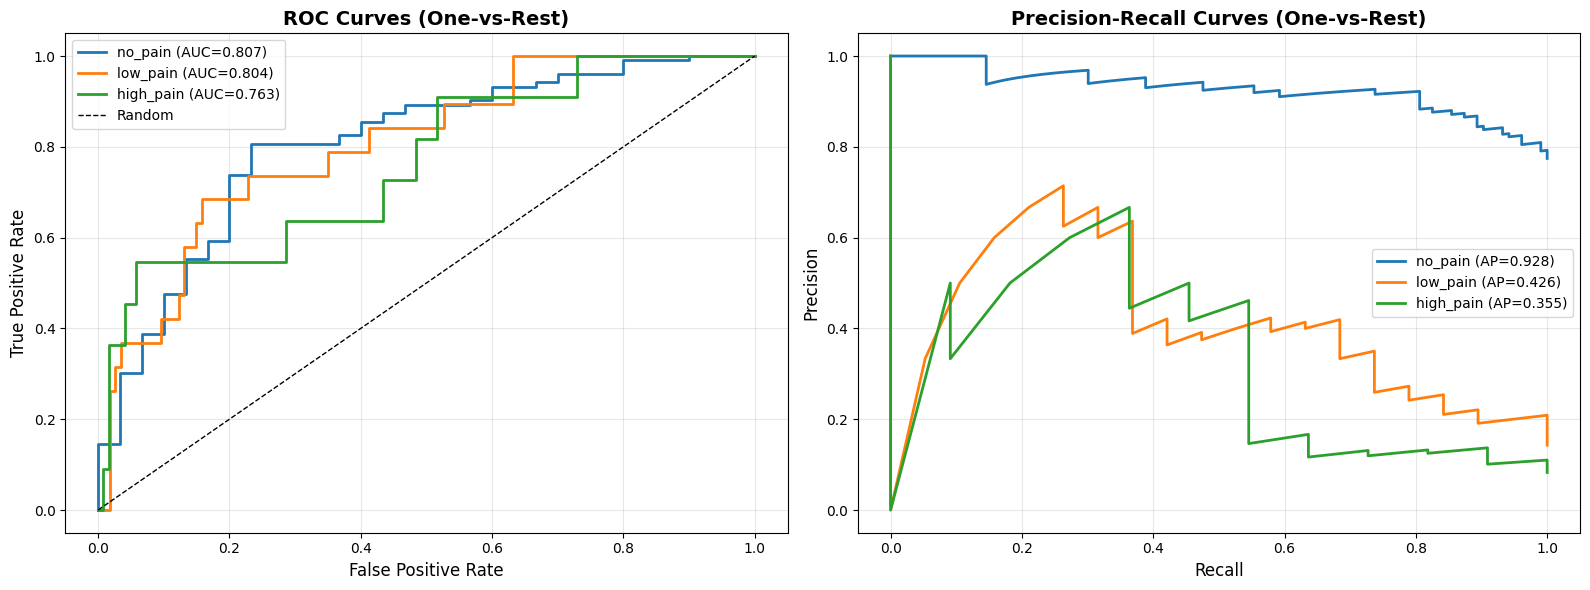

ROC and PR curves saved to ./figures/roc_pr_curves.png


In [ ]:
# ROC Curves (One-vs-Rest)
y_val_proba = best_model.predict(X_val, verbose=0)
y_val_binary = to_categorical(y_val, num_classes=num_classes)
label_names = [id_to_label[i] for i in range(num_classes)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val_binary[:, i], y_val_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"{label_names[i]} (AUC={roc_auc:.3f})", linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_val_binary[:, i], y_val_proba[:, i])
    avg_precision = average_precision_score(y_val_binary[:, i], y_val_proba[:, i])
    axes[1].plot(recall, precision, label=f"{label_names[i]} (AP={avg_precision:.3f})", linewidth=2)

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC and PR curves saved to ./figures/roc_pr_curves.png")

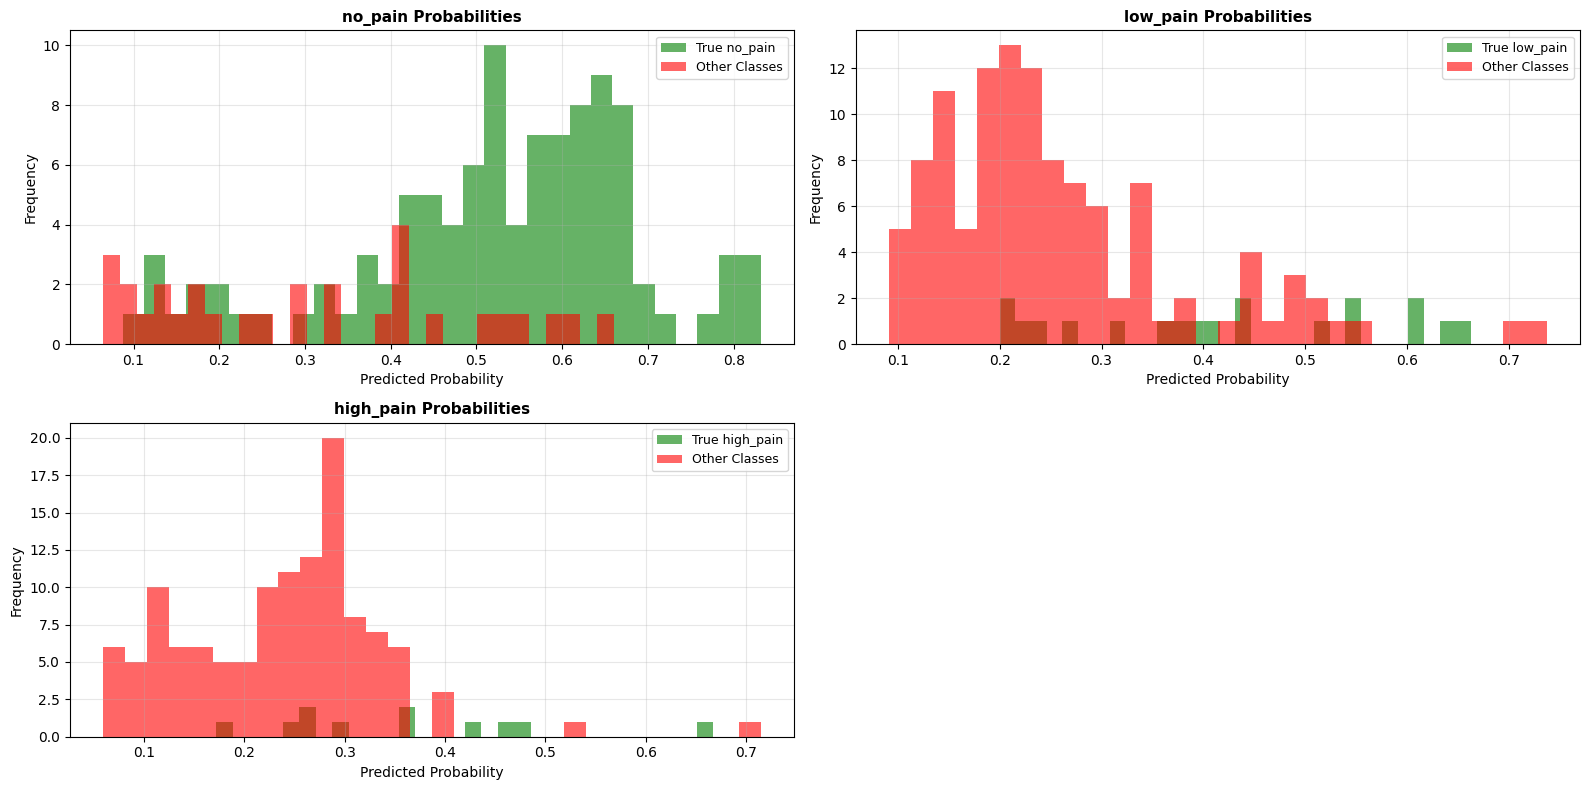

Probability distributions saved to ./figures/probability_distributions.png


In [ ]:
# Probability distributions per class
label_names = [id_to_label[i] for i in range(num_classes)]
fig, axes = plt.subplots(2, (num_classes + 1) // 2, figsize=(16, 8))
axes = axes.flatten()

for i in range(num_classes):
    true_class_probs = y_val_proba[y_val == i, i]
    false_class_probs = y_val_proba[y_val != i, i]
    
    axes[i].hist(true_class_probs, bins=30, alpha=0.6, label=f'True {label_names[i]}', color='green')
    axes[i].hist(false_class_probs, bins=30, alpha=0.6, label='Other Classes', color='red')
    axes[i].set_xlabel('Predicted Probability', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].set_title(f'{label_names[i]} Probabilities', fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

for i in range(num_classes, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('./figures/probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Probability distributions saved to ./figures/probability_distributions.png")

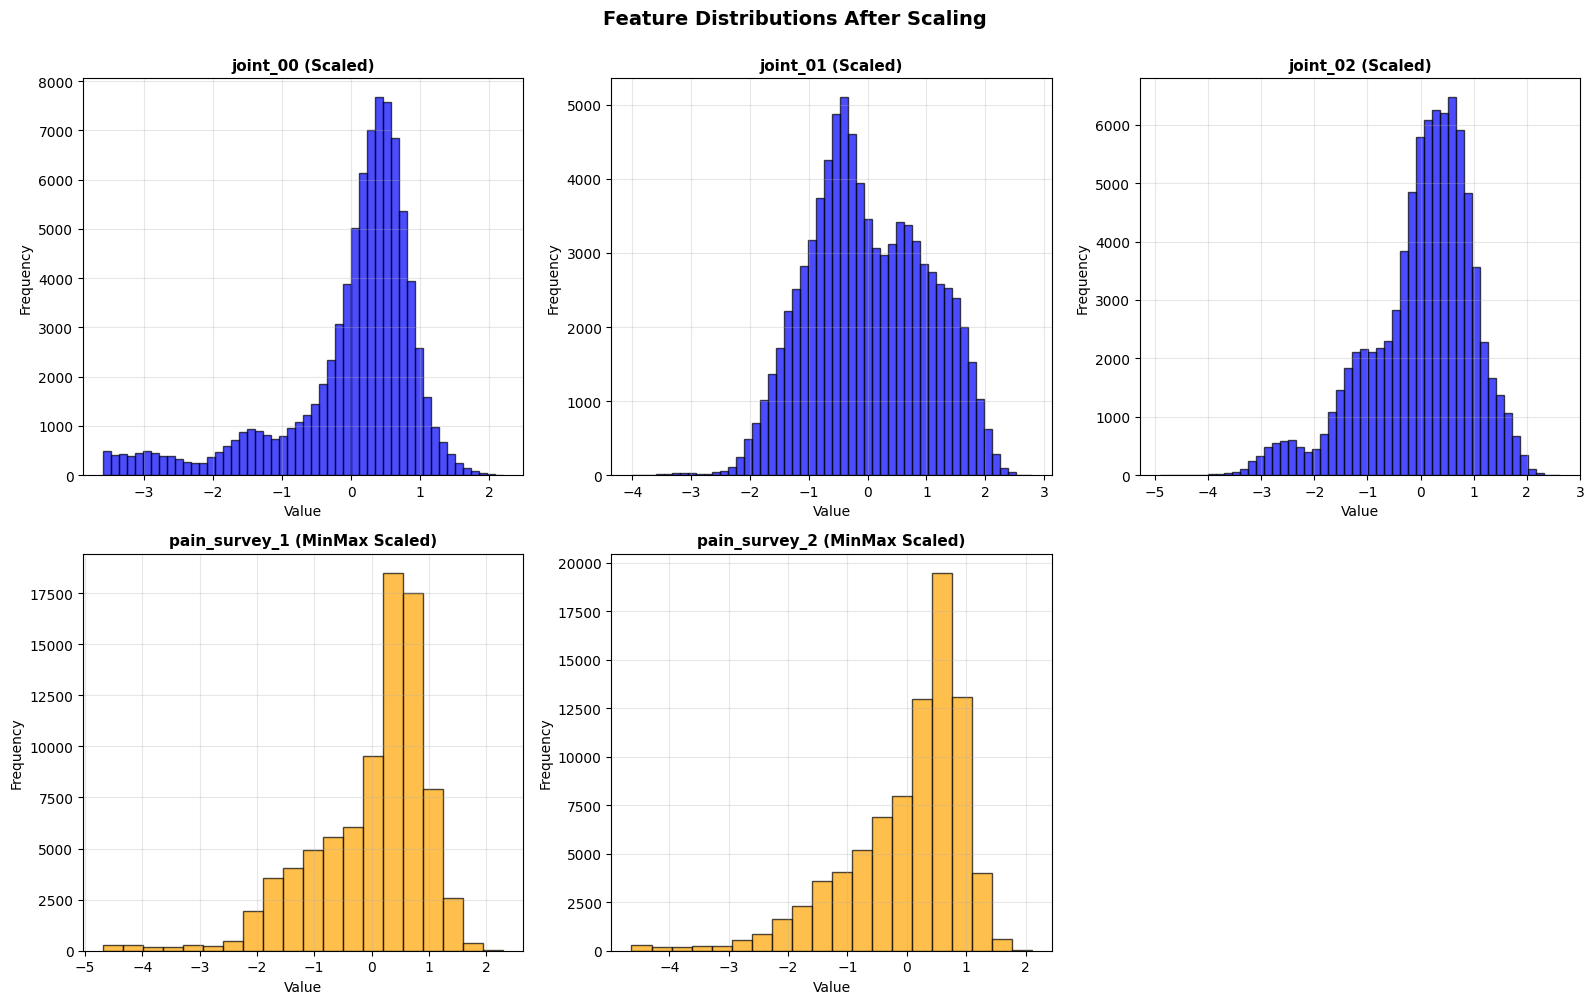

Feature distributions saved to ./figures/feature_distributions.png


In [ ]:
# Feature distribution visualization
sample_joint_cols = joint_cols[:3] if len(joint_cols) >= 3 else joint_cols
sample_survey_cols = survey_cols[:2] if len(survey_cols) >= 2 else survey_cols

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(sample_joint_cols):
    col_idx = all_feature_cols.index(col)
    feature_data = X_train[:, :, col_idx].flatten()
    axes[0, i].hist(feature_data, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, i].set_title(f'{col} (Scaled)', fontsize=11, fontweight='bold')
    axes[0, i].set_xlabel('Value', fontsize=10)
    axes[0, i].set_ylabel('Frequency', fontsize=10)
    axes[0, i].grid(True, alpha=0.3)

for i, col in enumerate(sample_survey_cols):
    col_idx = all_feature_cols.index(col)
    feature_data = X_train[:, :, col_idx].flatten()
    axes[1, i].hist(feature_data, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1, i].set_title(f'{col} (MinMax Scaled)', fontsize=11, fontweight='bold')
    axes[1, i].set_xlabel('Value', fontsize=10)
    axes[1, i].set_ylabel('Frequency', fontsize=10)
    axes[1, i].grid(True, alpha=0.3)

for i in range(len(sample_survey_cols), 3):
    axes[1, i].axis('off')

plt.suptitle('Feature Distributions After Scaling', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('./figures/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Feature distributions saved to ./figures/feature_distributions.png")

## 10. Test Predictions and Submission

In [ ]:
# Predict on test set
test_proba = best_model.predict(X_test, verbose=0)
test_pred = test_proba.argmax(axis=1)

print(f"Test predictions shape: {test_pred.shape}")
print(f"Test probabilities shape: {test_proba.shape}")

# Verify test sample indices match submission format
print(f"\nTest sample indices: {len(test_sample_indices)}")
print(f"Sample submission rows: {len(sample_submission)}")

Test predictions shape: (1324,)
Test probabilities shape: (1324, 3)

Test sample indices: 1324
Sample submission rows: 1324


In [ ]:
# Create submission file matching sample_submission format
submission_df = sample_submission.copy()

# Map test_sample_indices to predictions
pred_map = dict(zip(test_sample_indices, test_pred))

# Get the column names from sample_submission
id_col = sample_submission.columns[0]  # Usually 'id' or 'sample_index'
label_cols = sample_submission.columns[1:]  # Prediction columns

# Fill predictions with original label strings
for idx, row in submission_df.iterrows():
    sample_id = row[id_col]
    if sample_id in pred_map:
        predicted_class = int(pred_map[sample_id])
        predicted_label = id_to_label[predicted_class]
        submission_df.loc[idx, label_cols] = predicted_label

# Save submission
submission_df.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")
print(f"Submission shape: {submission_df.shape}")
print("Label mapping used for submission:", id_to_label)
print(f"\nFirst few rows:")
print(submission_df.head())

Submission saved to submission.csv
Submission shape: (1324, 2)
Label mapping used for submission: {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}

First few rows:
   sample_index      label
0             0  high_pain
1             1    no_pain
2             2    no_pain
3             3    no_pain
4             4    no_pain


In [ ]:
# Create submission with probabilities
prob_cols = [f"prob_{id_to_label[i]}" for i in range(num_classes)]
submission_probs_df = pd.DataFrame({
    id_col: test_sample_indices
})

for i, col in enumerate(prob_cols):
    submission_probs_df[col] = test_proba[:, i]

submission_probs_df.to_csv('submission_probs.csv', index=False)
print("Submission with probabilities saved to submission_probs.csv")
print(f"Submission probabilities shape: {submission_probs_df.shape}")
print("Probability column order:", prob_cols)
print(f"\nFirst few rows:")
print(submission_probs_df.head())

Submission with probabilities saved to submission_probs.csv
Submission probabilities shape: (1324, 4)
Probability column order: ['prob_no_pain', 'prob_low_pain', 'prob_high_pain']

First few rows:
   sample_index  prob_no_pain  prob_low_pain  prob_high_pain
0             0      0.214422       0.391856        0.393721
1             1      0.652302       0.212794        0.134905
2             2      0.528181       0.208703        0.263115
3             3      0.531941       0.156835        0.311224
4             4      0.600059       0.159697        0.240244


## Final Summary

In [ ]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nT_target: {T_target}")
print("\nLabel mapping (id -> label):")
for idx in range(num_classes):
    print(f"  {idx}: {id_to_label[idx]}")
print(f"Mapping saved to: {Path('label_mapping.json').resolve()}")

print(f"\nBest Configuration:")
for key, value in best_config.items():
    print(f"  {key}: {value}")
print(f"\nValidation Metrics:")
print(f"  Macro F1: {f1_macro:.4f}")
print(f"  Accuracy: {(y_val_pred == y_val).mean():.4f}")

print(f"\nF1 Scores per Class:")
for i, f1 in enumerate(f1_per_class):
    print(f"  {id_to_label[i]}: {f1:.4f}")

print("\nOutput Files:")
print("  - submission.csv")
print("  - submission_probs.csv")
print("  - best_config.json")
print("  - label_mapping.json")
print("  - ./figures/training_curves.png")
print("  - ./figures/confusion_matrix.png")
print("  - ./figures/roc_pr_curves.png")
print("  - ./figures/probability_distributions.png")
print("  - ./figures/feature_distributions.png")
print("="*60)

FINAL SUMMARY

T_target: 160

Label mapping (id -> label):
  0: no_pain
  1: low_pain
  2: high_pain
Mapping saved to: C:\Users\filip\Documents\GitHub\challenge_an2dl\label_mapping.json

Best Configuration:
  units1: 128
  units2: 48
  head_units: 64
  lr: 0.0006
  weight_decay: 0.0002

Validation Metrics:
  Macro F1: 0.6317
  Accuracy: 0.7744

F1 Scores per Class:
  no_pain: 0.8614
  low_pain: 0.4783
  high_pain: 0.5556

Output Files:
  - submission.csv
  - submission_probs.csv
  - best_config.json
  - label_mapping.json
  - ./figures/training_curves.png
  - ./figures/confusion_matrix.png
  - ./figures/roc_pr_curves.png
  - ./figures/probability_distributions.png
  - ./figures/feature_distributions.png
